# Using Python tools for a analysis of COVID-19 data

# ARIMA method to forecast

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product 
from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

In [3]:
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [4]:
mpl.rcParams['font.size'] = 15.0

In [5]:
pd.set_option("display.precision", 5)
pd.set_option('display.max_rows', 15)

### Time Series Components 
<div style="text-align: justify">A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.</div>
<ul>
    <li><b>Systematic:</b> Components of the time series that have consistency or recurrence and can be described and modeled.</li>
    <li><b>Non-Systematic:</b> Components of the time series that cannot be directly modeled.</li>
</ul>
<div style="text-align: justify">A given time series is thought to consist of three systematic components including <b>level</b>, <b>trend</b>, <b>seasonality</b>, and one non-systematic component called <b>noise</b>.</div>
<ul>
    <li><b>Level:</b> The average value in the series.</li>
    <li><b>Trend:</b> The increasing or decreasing value in the series.</li>
    <li><b>Seasonality:</b> The repeating short-term cycle in the series.</li>
    <li><b>Noise:</b> The random variation in the series.


### <span style="color:red">Analysis of the last N days</span>

In [6]:
Ndays = '150days'

### <span style="color:red">Day range for matplotlib</span>

In [7]:
Ninterval = 7

In [8]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

In [9]:
#filename = '/home/davi/Documents/Python/Covid-19-Data/owid-covid-data.csv'

In [10]:
df = pd.read_csv(url)
# df = pd.read_csv(filename)
df['date'] = pd.to_datetime(df['date'])
df['location'] = df['location'].replace(['United States'],'United_States')
df['location'] = df['location'].replace(['United Kingdom'],'United_Kingdom')

In [11]:
df = df.loc[:,['date', 'location', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
df = df[df['date'] > pd.to_datetime("today") - pd.to_timedelta(Ndays)]
df = df.sort_values(by=['total_cases'], ascending=True)

# Number of cases and deaths in World

In [12]:
dfWorld = df[df['location'] == 'World']
dfWorld = dfWorld.sort_values(by='date', ascending=True)
dfWorld = dfWorld.loc[:,['date', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
dfWorld.reset_index(drop=True, inplace=True)
dfWorld.tail(15)

,date,total_cases,total_deaths,new_cases,new_deaths
134,2020-08-17,21704804.0,770213.0,232369.0,4223.0
135,2020-08-18,21901186.0,774471.0,196382.0,4258.0
136,2020-08-19,22156092.0,781152.0,254906.0,6681.0
137,2020-08-20,22437222.0,787685.0,281130.0,6533.0
138,2020-08-21,22713387.0,794027.0,276165.0,6342.0
139,2020-08-22,22967090.0,799939.0,253703.0,5912.0
140,2020-08-23,23233866.0,805573.0,266776.0,5634.0
141,2020-08-24,23458523.0,808896.0,224657.0,3323.0
142,2020-08-25,23669726.0,813141.0,211203.0,4245.0
143,2020-08-26,23924750.0,819639.0,255024.0,6498.0


In [13]:
ads = dfWorld.loc[:,['date','new_cases']]
ads = ads.set_index('date')

In [14]:
currency = dfWorld.loc[:,['date','new_deaths']]
currency = currency.set_index('date')

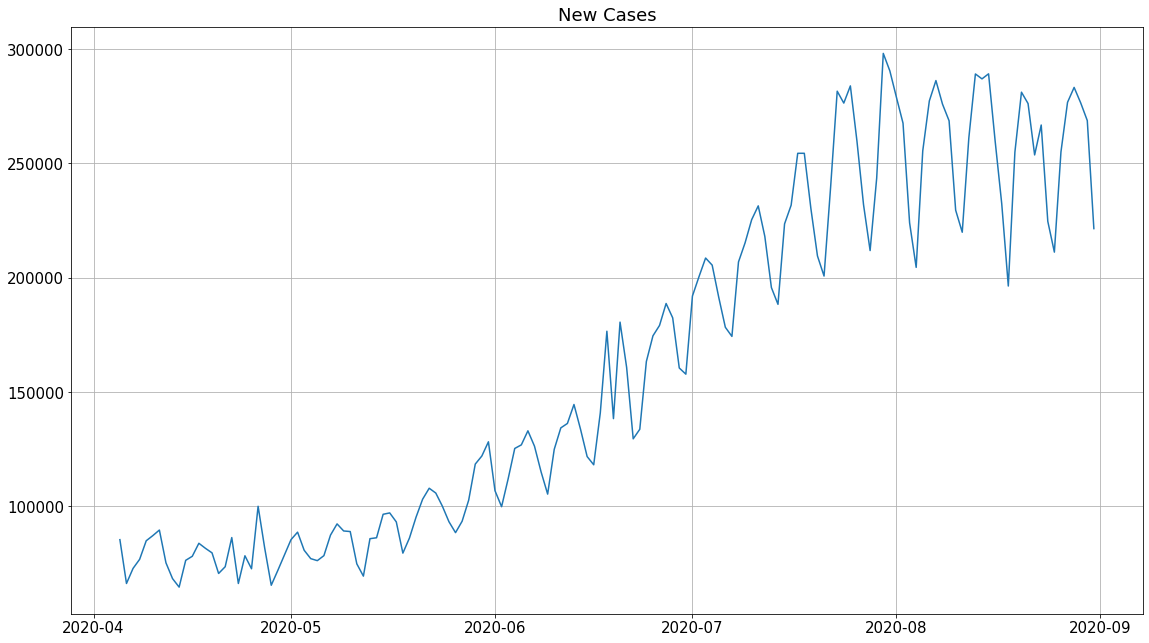

In [15]:
plt.figure(figsize=(19.20,10.80))
plt.plot(ads.new_cases)
plt.title('New Cases')
plt.grid(True)
plt.show()

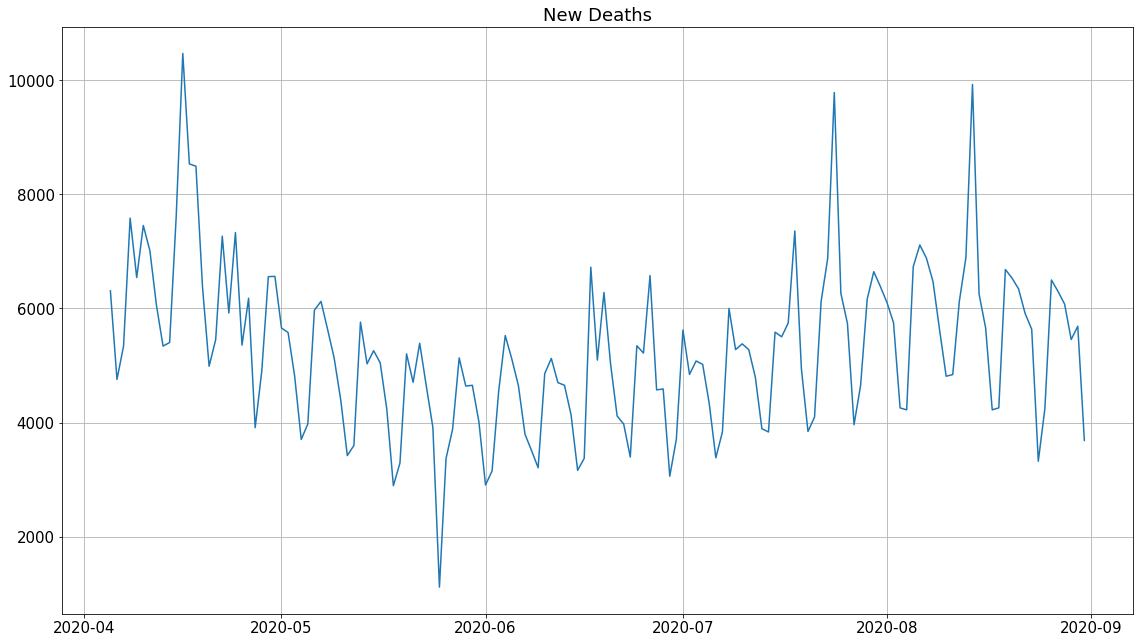

In [16]:
plt.figure(figsize=(19.20,10.80))
plt.plot(currency.new_deaths)
plt.title('New Deaths')
plt.grid(True)
plt.show()

#### Mean Absolute Error (MAE)
<div style="text-align: justify">MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.</div>
<br>
<div style="font-size:20px"><center>$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$</center></div>
<br>
<div style="text-align: justify">Where, $\hat{y}_i$ is the predicted value of the <i>i</i>-th sample, $y_i$ is the corresponding true value and <i>n</i> is the number of samples.

#### Mean Absolute Percentage Error (MAPE)
<div style="text-align: justify">MAPE measures the size of the error in percentage terms. It is calculated as the average of the unsigned percentage error.</div>
<br>
<div style="font-size:20px"><center>$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$</center></div>

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### Moving Average
<div style="text-align: justify">The future value $\hat{y}_i$ of our variable depends on the average of its <i>k</i> previous values.
<div style="font-size:20px"><center>$\hat{y}_{i} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{i-n}$</center></div>

In [18]:
def moving_average(series, n):
    return np.average(series[-n:])

In [19]:
moving_average(ads, 7)

256115.85714285713

In [20]:
moving_average(currency, 7)

5420.714285714285

In [21]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(19.20, 10.80))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "g--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "g--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

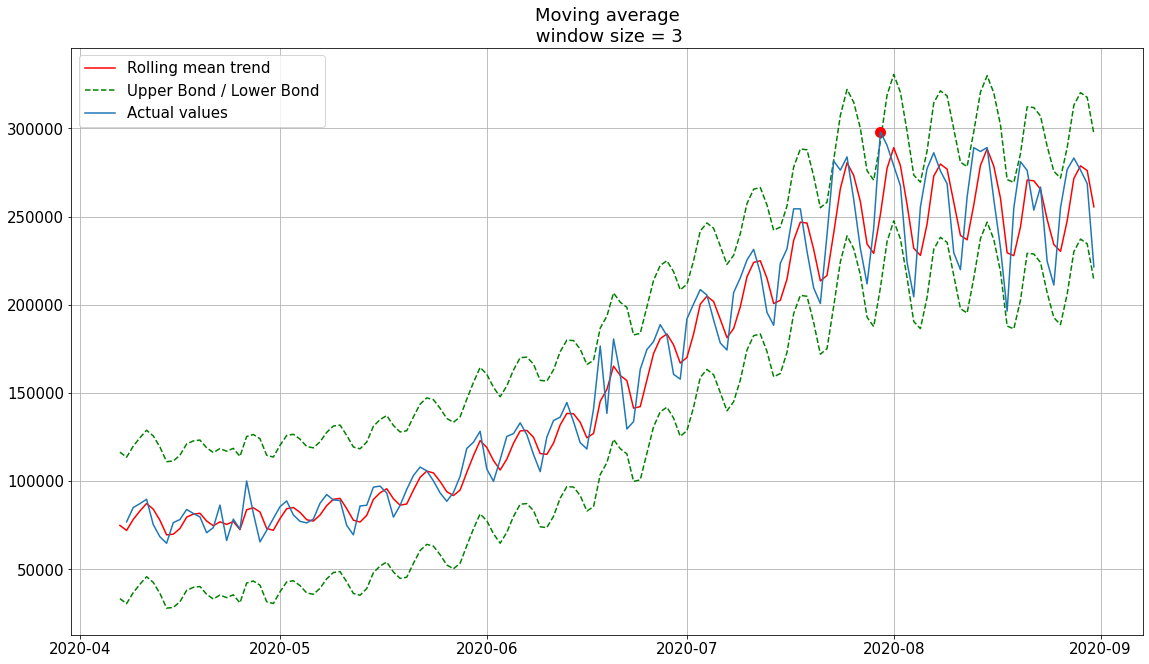

In [22]:
plotMovingAverage(ads, 3, plot_intervals=True, plot_anomalies=True)

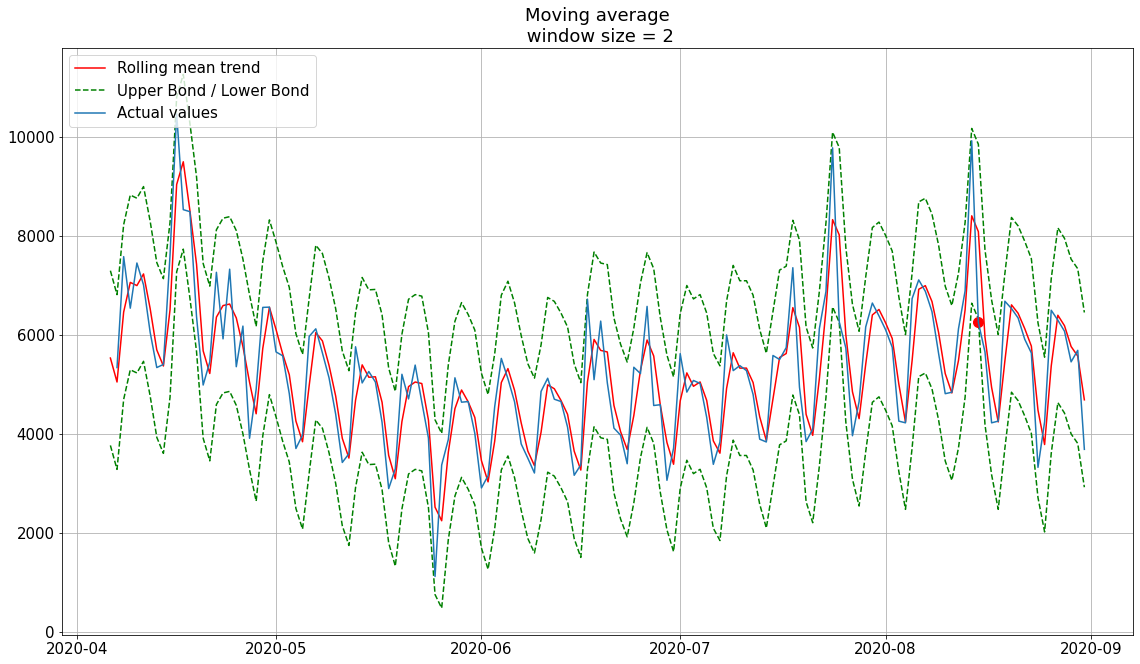

In [23]:
plotMovingAverage(currency, 2, plot_intervals=True, plot_anomalies=True)

#### Weighted Average
<div style="text-align: justify">A weighted average is the average of a data set that recognizes certain numbers as more important than others. In calculating a weighted average, each number in the data set is multiplied by a predetermined weight before the final calculation is made.
A weighted average can be more accurate than a simple average in which all numbers in a data set are assigned an identical weight.</div>
<br>
<div style="font-size:20px"><center>$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$</center>

In [24]:
def weighted_average(series, weights):
    result = 0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [25]:
weighted_average(ads, [0.6, 0.3, 0.1])

268635.9

#### Exponential Smoothing
<div style="text-align: justify">Exponential Smoothing assigns exponentially decreasing weights as the observation get older.In other words, recent observations are given relatively more weight in forecasting than the older observations.</div>
<br>
<div style="font-size:20px"><center>$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1}$</center>

In [26]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
        
    return result

In [27]:
def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(19.20,10.80))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label='Alpha {}'.format(alpha))
            
        plt.plot(series.values, 'b--', label='Actual')
        plt.legend(loc='best')
        plt.axis('tight')
        plt.title('Exponential Smoothing')
        plt.grid(True)

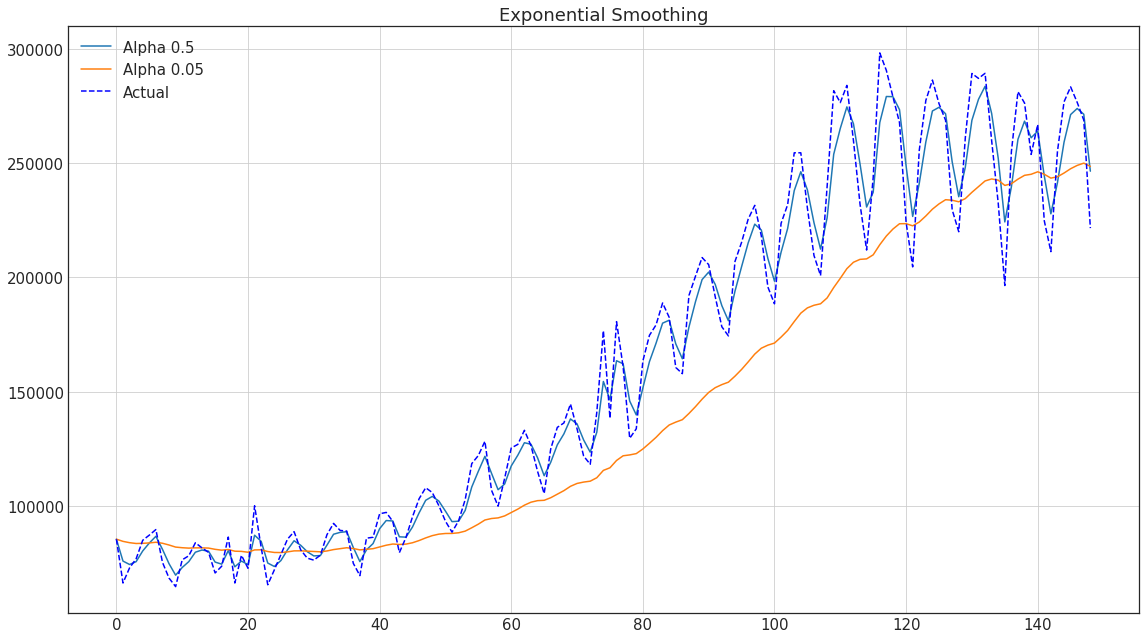

In [28]:
plotExponentialSmoothing(ads.new_cases, [0.5, 0.05])

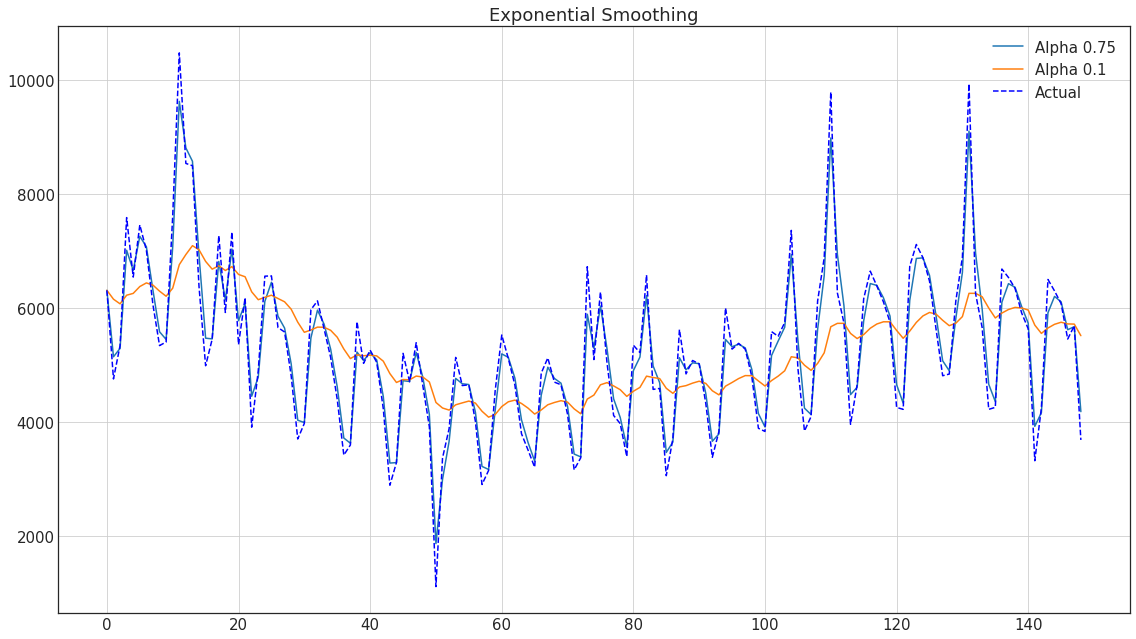

In [29]:
plotExponentialSmoothing(currency.new_deaths, [0.75, 0.1])

#### Double exponential smoothing

In [30]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        
        if n >= len(series):
            value = result[-1]
        
        else:
            value = series[n]
        
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [31]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(19.20,10.80))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta),
                         label='Alpha {}, Beta {}'.format(alpha,beta))
                plt.plot(series.values, label='Actual')
                plt.legend(loc='best')
                plt.axis('tight')
                plt.title('Double Exponential Smoothing')
                plt.grid(True)

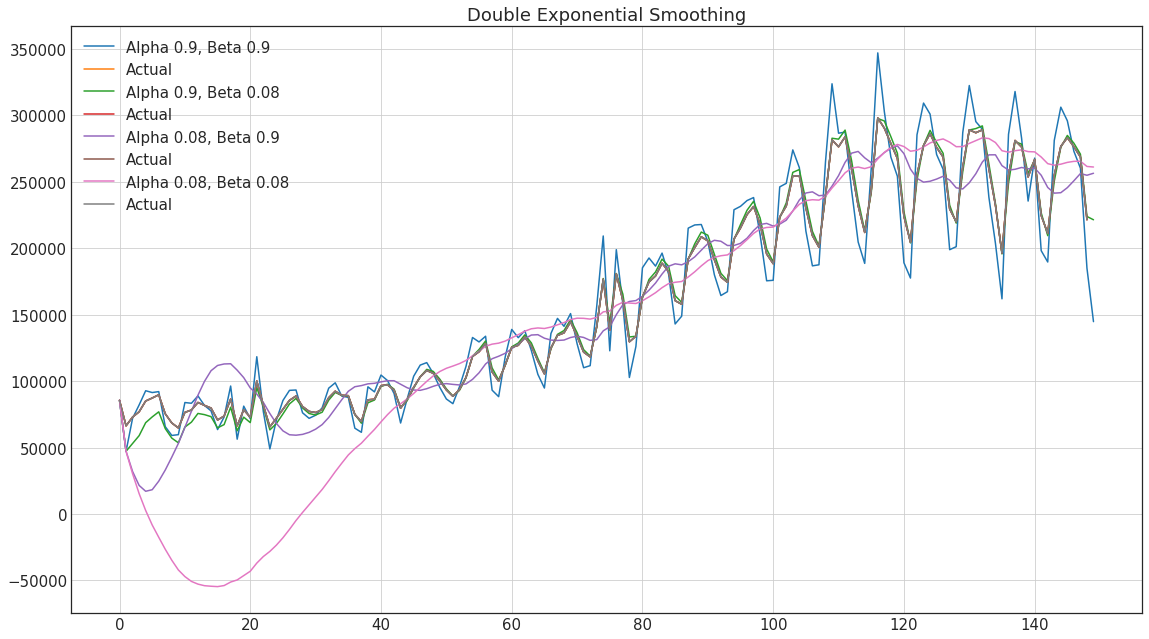

In [32]:
plotDoubleExponentialSmoothing(ads.new_cases, alphas=[0.9, 0.08], betas=[0.9, 0.08])

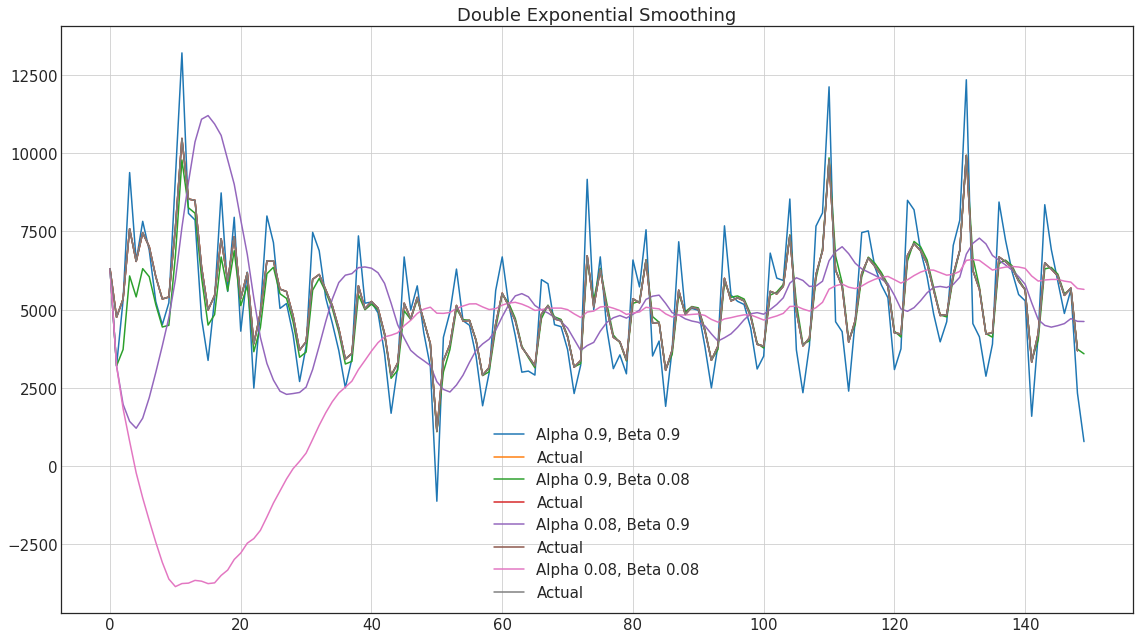

In [33]:
plotDoubleExponentialSmoothing(currency.new_deaths, alphas=[0.9, 0.08], betas=[0.9, 0.08])

#### Triple Exponential Smoothing 

In [35]:
class HoltWinters:
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

#### Source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

#### Source: https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python